# Gradient boosting

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

concrete = pd.read_csv('data/concrete_data.csv')
concrete.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [2]:
X = concrete.drop('csMPa', axis=1)
Y = concrete['csMPa']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [3]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=3)
tree_reg1.fit(x_train, y_train)
y2 = y_train - tree_reg1.predict(x_train)
y2[:10]

1016   -10.724545
101     -5.326327
805      1.875962
61      11.755621
720     11.885621
965     16.645621
33      -4.784038
121      4.380921
864     -8.104379
825     -7.824038
Name: csMPa, dtype: float64

In [4]:
tree_reg2 = DecisionTreeRegressor(max_depth=4)
tree_reg2.fit(x_train, y2)
y3 = y2 - tree_reg2.predict(x_train)
y3[:10]

1016    1.709898
101    -6.821795
805    -1.886569
61      3.562033
720     3.692033
965     6.740536
33     -8.546569
121     2.885453
864    -1.989673
825    -1.709333
Name: csMPa, dtype: float64

In [5]:
tree_reg3 = DecisionTreeRegressor(max_depth=5)
tree_reg3.fit(x_train, y3)
y_pred = sum(tree.predict(x_test) for tree in (tree_reg1, tree_reg2, tree_reg3))

from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.8300912906901196

In [6]:
y4 = y3 - tree_reg3.predict(x_train)
y4[:10]

1016    3.161680
101    -0.716474
805    -1.338646
61     -1.047708
720    -5.694685
965     2.005513
33     -5.107384
121     3.433376
864     0.300000
825    -1.161410
Name: csMPa, dtype: float64

In [7]:
tree_reg4 = DecisionTreeRegressor(max_depth=5)
tree_reg4.fit(x_train, y4)
y_pred = sum(tree.predict(x_test) for tree in (tree_reg1, tree_reg2, tree_reg3, tree_reg4))
r2_score(y_test, y_pred)

0.8541711800950658

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(max_depth=3, n_estimators=3, learning_rate=1.0)
gbr.fit(x_train, y_train)
y_pred = gbr.predict(x_test)
r2_score(y_test, y_pred)

0.7536621480059218

In [9]:
gbr = GradientBoostingRegressor(max_depth=3, n_estimators=3, learning_rate=0.1)
gbr.fit(x_train, y_train)
y_pred = gbr.predict(x_test)
r2_score(y_test, y_pred)

0.2965505407539778

In [10]:
gbr = GradientBoostingRegressor(max_depth=3, n_estimators=30, learning_rate=0.1)
gbr.fit(x_train, y_train)
y_pred = gbr.predict(x_test)
r2_score(y_test, y_pred)

0.8314122742784492

# Hyperparameter tuning

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

concrete = pd.read_csv('data/concrete_data.csv')

X = concrete.drop('csMPa', axis=1)
Y = concrete['csMPa']
X = X.drop(['flyash', 'coarseaggregate', 'fineaggregate'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

baseline = GradientBoostingRegressor(max_depth=3, n_estimators=50)
baseline.fit(x_train, y_train)
y_pred = baseline.predict(x_test)
r2_score(y_test, y_pred)

0.896574996472733

In [12]:
important_features = pd.Series(baseline.feature_importances_, index=X.columns).\
                        sort_values(ascending=False)

important_features

age                 0.378844
cement              0.320274
water               0.107596
superplasticizer    0.105687
slag                0.087599
dtype: float64

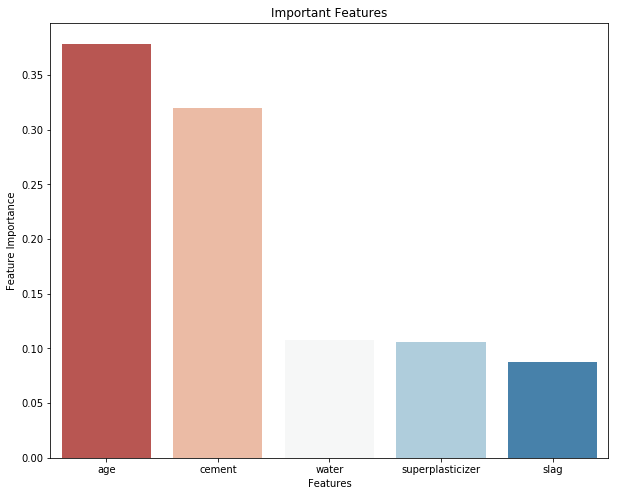

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot( x = important_features.index, y = important_features, palette = "RdBu")
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title("Important Features")
plt.show()

In [16]:
min_val_error = float("inf")
error_increasing = 0

for n_estimators in range(1, 1000):
    gbr.n_estimators = n_estimators
    gbr.fit(x_train, y_train)
    
    y_pred = gbr.predict(x_test)
    val_error = mean_squared_error(y_test, y_pred)
    
    print('No. of estimators: ', gbr.n_estimators_)
    print('Validation error: ', val_error)
    
    if val_error < min_val_error:
        min_val_error = val_error
        error_increasing = 0
    else:
        error_increasing += 1
        if error_increasing == 10:
            break

No. of estimators:  1
Validation error:  269.7139748356637
No. of estimators:  2
Validation error:  239.54411434535814
No. of estimators:  3
Validation error:  213.47579065685193
No. of estimators:  4
Validation error:  190.4681193504418
No. of estimators:  5
Validation error:  171.30627511420226
No. of estimators:  6
Validation error:  155.5572118878301
No. of estimators:  7
Validation error:  141.60490538285336
No. of estimators:  8
Validation error:  131.10048226917033
No. of estimators:  9
Validation error:  121.40029814695123
No. of estimators:  10
Validation error:  112.44759057085561
No. of estimators:  11
Validation error:  105.54776196906244
No. of estimators:  12
Validation error:  98.97878742494416
No. of estimators:  13
Validation error:  91.41782106893416
No. of estimators:  14
Validation error:  86.28505817408809
No. of estimators:  15
Validation error:  82.50044876320435
No. of estimators:  16
Validation error:  78.13494058206611
No. of estimators:  17
Validation error: 

No. of estimators:  137
Validation error:  23.240114284496325
No. of estimators:  138
Validation error:  23.109178061190384
No. of estimators:  139
Validation error:  23.10131822973077
No. of estimators:  140
Validation error:  23.12252236848743
No. of estimators:  141
Validation error:  23.106625089396253
No. of estimators:  142
Validation error:  23.072567731632756
No. of estimators:  143
Validation error:  23.101053646165298
No. of estimators:  144
Validation error:  23.01621003666886
No. of estimators:  145
Validation error:  22.96913776915338
No. of estimators:  146
Validation error:  22.940628754984733
No. of estimators:  147
Validation error:  22.7822442287179
No. of estimators:  148
Validation error:  22.798174755522037
No. of estimators:  149
Validation error:  22.794731575644157
No. of estimators:  150
Validation error:  22.72242821107895
No. of estimators:  151
Validation error:  22.684402678555713
No. of estimators:  152
Validation error:  22.67680095140429
No. of estimator

No. of estimators:  273
Validation error:  19.64667403151279
No. of estimators:  274
Validation error:  19.85361996880571
No. of estimators:  275
Validation error:  19.653009940252957
No. of estimators:  276
Validation error:  19.68464400559054
No. of estimators:  277
Validation error:  19.66993980702935
No. of estimators:  278
Validation error:  19.585801780943687
No. of estimators:  279
Validation error:  19.61804311469438
No. of estimators:  280
Validation error:  19.453963484593807
No. of estimators:  281
Validation error:  19.64573487604055
No. of estimators:  282
Validation error:  19.608044386969382
No. of estimators:  283
Validation error:  19.58147108309774
No. of estimators:  284
Validation error:  19.771260605408756
No. of estimators:  285
Validation error:  19.628884735432152
No. of estimators:  286
Validation error:  19.791712225987386
No. of estimators:  287
Validation error:  19.742027867487508
No. of estimators:  288
Validation error:  19.77864510455311
No. of estimator

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
gbr_best = GradientBoostingRegressor(max_depth=3,
                                     n_estimators = n_estimators)
gbr_best.fit(x_train, y_train)
y_pred = gbr_best.predict(x_test)
r2_score(y_test, y_pred)

0.9186826622158041